#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

## Подготовка

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi = taxi.sort_index(ascending=True)

In [5]:
taxi_day = taxi.resample('1D').sum()

In [6]:
taxi = taxi.resample('1H').sum()

**Вывод**: данные были подготовлены и рассемплированы по одному часу.

## Анализ

Разделим данные на трендовую, сезонную и шумовую состовляющие и построим графики:

In [7]:
decomposed = seasonal_decompose(taxi)

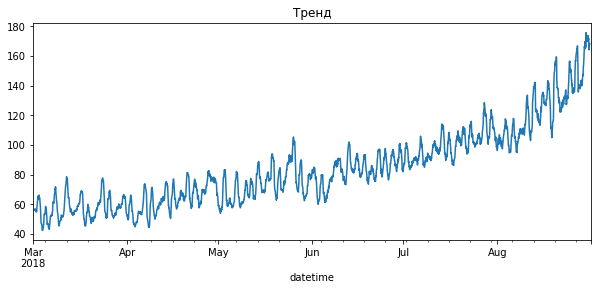

In [8]:
decomposed.trend.plot(figsize=(10, 4), title='Тренд');

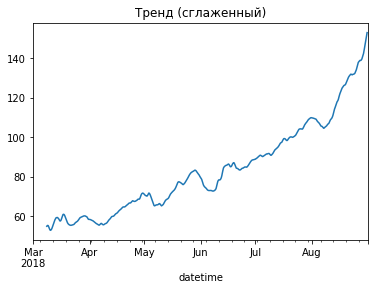

In [9]:
decomposed.trend.rolling(24*7).mean().plot(title='Тренд (сглаженный)');

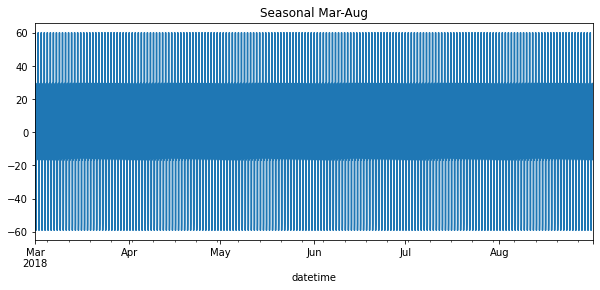

In [10]:
decomposed.seasonal.plot(figsize=(10, 4), title='Seasonal Mar-Aug');

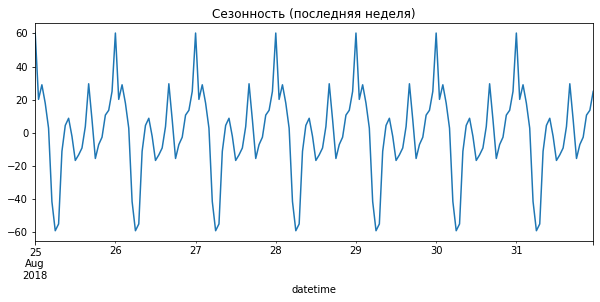

In [11]:
decomposed.seasonal.tail(24*7).plot(figsize=(10, 4), title='Сезонность (последняя неделя)');

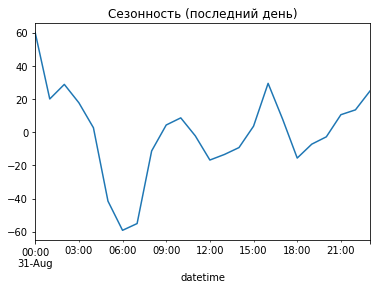

In [12]:
decomposed.seasonal.tail(24).plot(title='Сезонность (последний день)');

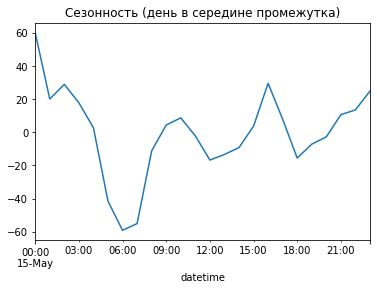

In [13]:
decomposed.seasonal['2018-05-15'].plot(title='Сезонность (день в середине промежутка)');

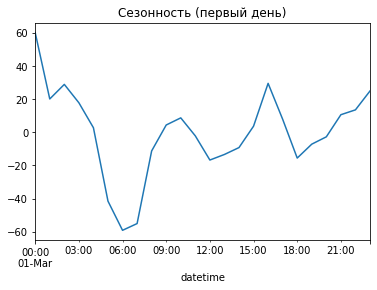

In [14]:
decomposed.seasonal.head(24).plot(title='Сезонность (первый день)');

По графикам можно заметить, что сезонность составляет 24 часа, и со временем она не меняется.

In [15]:
decomposed_day = seasonal_decompose(taxi_day)

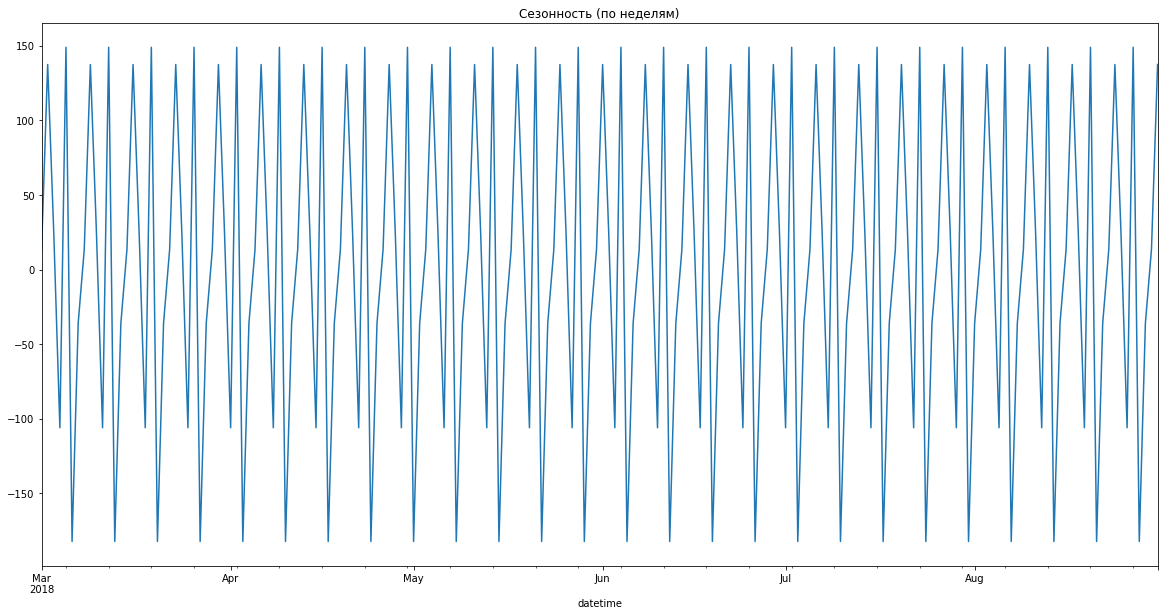

In [16]:
decomposed_day.seasonal.plot(title='Сезонность (по неделям)', figsize=(20, 10));

По графикам можно заметить, что также присутствует сезонность, которая состовляет 7 суток (неделю).

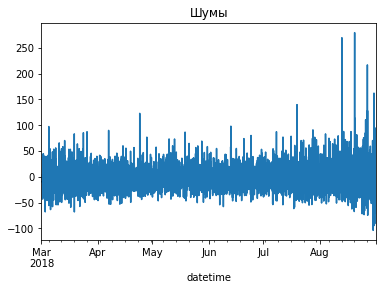

In [17]:
decomposed.resid.plot(title='Шумы');

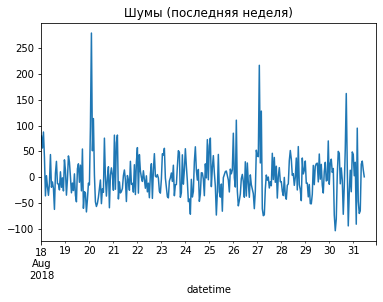

In [18]:
decomposed.resid.tail(24*14).plot(title='Шумы (последняя неделя)');

Проверим является ли наш ряд стационарным. Для этого применим тест Дики-Фуллера.

In [19]:
#taxi['mean'] = taxi['num_orders'].rolling(12).mean()
#taxi['std'] = taxi['num_orders'].rolling(12).std()
#taxi.plot(figsize=(10, 4));

In [20]:
#taxi = taxi.drop(['mean', 'std'], axis=1)

In [21]:
#taxi_copy = taxi.copy()

In [22]:
#taxi = taxi - taxi_copy.shift()

In [23]:
#taxi['mean'] = taxi['num_orders'].rolling(12).mean()
#taxi['std'] = taxi['num_orders'].rolling(12).std()
#taxi.plot(figsize=(10, 4));

In [24]:
#taxi = taxi.drop(['mean', 'std'], axis=1)

В итоге получили стационарный ряд.

In [25]:
from statsmodels.tsa.stattools import adfuller

taxi_t = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi_t['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


**Вывод:**
- по графику тренда можно заметить, что в приниципе заказов становится больше;
- по графику сезонности можно заметить, что сезонность составляет 1 сутки;

## Обучение

### Подготовка данных

Создадим функцию для создания признаков:

In [26]:
def make_features(taxi, column, max_lag, rolling_mean_size):
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour

    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi[column].shift(lag)

    taxi['rolling_mean'] = taxi[column].shift().rolling(rolling_mean_size).mean()


In [27]:
make_features(taxi, 'num_orders', 24*7, 48)

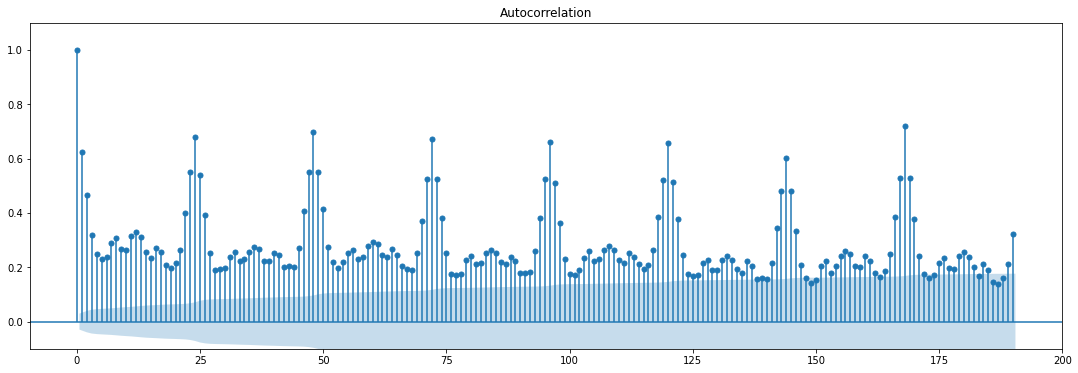

In [28]:
from statsmodels.graphics import tsaplots

taxi_n = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi_n['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

In [29]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna() 
test = test.dropna() 

In [30]:
feautures_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

feautures_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Рассмотрим четыре модели:
- Линейная регрессия;
- Случайный лес;
- CatBoostRegressor;
- LGBMRegressor.

### Линейная регрессия

In [31]:
regressor = LinearRegression()
tscv = TimeSeriesSplit(n_splits=3)
cv_RMSE_LR = (cross_val_score(regressor, 
                             feautures_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print(f'RMSE на линейной регрессии - {(cv_RMSE_LR):.3f}')

RMSE на линейной регрессии - 23.236


### Случайный лес

In [32]:
model = RandomForestRegressor(random_state = 123)
parametres_rf = {'max_depth':range(2,6),
                'n_estimators': range(50,201,50)}
tscv = TimeSeriesSplit(n_splits=3)
grid_rf = GridSearchCV(model,
                         parametres_rf,
                         cv=tscv,
                         n_jobs=-1,
                         scoring = 'neg_root_mean_squared_error',
                         verbose = 2)
grid_rf.fit(feautures_train, target_train)
print()
print(f'Лучшие гиперпараметры для модели - {grid_rf.best_params_}')
print(f'Значение RMSE при лучших гиперпараметрах - {abs(grid_rf.best_score_):.3f}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.8s
[CV] END .......................max_depth=2, n_estimators=50; total time=   1.3s
[CV] END .......................max_depth=2, n_estimators=50; total time=   1.8s
[CV] END ......................max_depth=2, n_estimators=100; total time=   1.3s
[CV] END ......................max_depth=2, n_estimators=100; total time=   2.3s
[CV] END ......................max_depth=2, n_estimators=100; total time=   3.4s
[CV] END ......................max_depth=2, n_estimators=150; total time=   1.9s
[CV] END ......................max_depth=2, n_estimators=150; total time=   3.5s
[CV] END ......................max_depth=2, n_estimators=150; total time=   5.0s
[CV] END ......................max_depth=2, n_estimators=200; total time=   2.5s
[CV] END ......................max_depth=2, n_estimators=200; total time=   4.9s
[CV] END ......................max_depth=2, n_es

### CatBoostRegressor

In [33]:
%%time
parameters = {'depth': [3,4, 5, 6, 7],
              'learning_rate': [0.01,0.04],
              'iterations': [50,80,100, 200]}
CBC = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=3)
grid_CBC = GridSearchCV(estimator=CBC,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv = tscv)
grid_CBC.fit(feautures_train, target_train, silent=True)

CPU times: user 4min 55s, sys: 2.46 s, total: 4min 57s
Wall time: 6min


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff34d228100>,
             param_grid={'depth': [3, 4, 5, 6, 7],
                         'iterations': [50, 80, 100, 200],
                         'learning_rate': [0.01, 0.04]},
             scoring='neg_root_mean_squared_error')

In [34]:
print()
print(f'Лучшие гиперпараметры для модели - {grid_CBC.best_params_}')
print(f'Значение RMSE при лучших гиперпараметрах - {abs(grid_CBC.best_score_):.3f}')


Лучшие гиперпараметры для модели - {'depth': 3, 'iterations': 200, 'learning_rate': 0.04}
Значение RMSE при лучших гиперпараметрах - 23.441


### LGBMRegressor

In [35]:
lgb_model = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=3)
lgb_model = GridSearchCV(lgb_model,
                        param_grid={
                            'n_estimators': range(100, 201, 50),
                            'max_depth': range(4, 9, 2)},
                        scoring='neg_root_mean_squared_error',
                        verbose=3,
                        cv = tscv)
lgb_model.fit(feautures_train, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ..................max_depth=4, n_estimators=100; total time=   0.8s
[CV 2/3] END ..................max_depth=4, n_estimators=100; total time=   1.1s
[CV 3/3] END ..................max_depth=4, n_estimators=100; total time=   1.4s
[CV 1/3] END ..................max_depth=4, n_estimators=150; total time=   1.0s
[CV 2/3] END ..................max_depth=4, n_estimators=150; total time=   1.5s
[CV 3/3] END ..................max_depth=4, n_estimators=150; total time=   6.4s
[CV 1/3] END ..................max_depth=4, n_estimators=200; total time=   1.7s
[CV 2/3] END ..................max_depth=4, n_estimators=200; total time=   2.0s
[CV 3/3] END ..................max_depth=4, n_estimators=200; total time=   2.7s
[CV 1/3] END ..................max_depth=6, n_estimators=100; total time=   1.4s
[CV 2/3] END ..................max_depth=6, n_estimators=100; total time=   3.1s
[CV 3/3] END ..................max_depth=6, n_est

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'max_depth': range(4, 9, 2),
                         'n_estimators': range(100, 201, 50)},
             scoring='neg_root_mean_squared_error', verbose=3)

In [36]:
print()
print(f'Лучшие гиперпараметры для модели - {lgb_model.best_params_}')
print(f'Значение RMSE при лучших гиперпараметрах - {abs(lgb_model.best_score_):.3f}')


Лучшие гиперпараметры для модели - {'max_depth': 4, 'n_estimators': 100}
Значение RMSE при лучших гиперпараметрах - 23.661


Лучшие показатели RMSE у Линейной регрессии, проверим RMSE на тестовой выборке.

## Тестирование

In [37]:
model = LinearRegression();
model.fit(feautures_train, target_train)

LinearRegression()

In [38]:
predictions_test = model.predict(feautures_test)

In [39]:
rmse_cb = mean_squared_error(target_test, predictions_test)**0.5
print(round(rmse_cb,3))

34.805


In [41]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print(f'RMSE: {round(mean_squared_error(target_test,pred_previous)**0.5,3)}')

RMSE: 58.856


34.805 < 58.856 значит модель прошла проверку на адекватность.

## Вывод

В рамках проекта было выполнено следующее:
- Данные были загружены и выполнено ресемплирование по одному часу.
- Данные были проанализированы: 
        - количество заказов  со временем растет;
        - есть суточная и недельная сезонность;
        - из нестационарного ряда было преобразовано в стационарный.
- Были обучены разные модели (Линейная регрессия, Случайный лес, CatBoostRegressor,LGBMRegressor) с различными гиперпараметрами. Лучшее RMSE показала модель Линейной регрессии (23.236).

- Данные были проверены на тестовой выборке и на модели Линейной регрессии было получено *RMSE* 34.805 (<48).


